In [2]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [54]:
def smooth_timeseries(t, size=5):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2, size // 2)], mode='edge')
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=0, arr=t)

In [55]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [56]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [875]:
county = 1879
z = deaths[county] 
z = z[z != 0]
init = [z[0]]
z1 = np.diff(z)
init.append(z1[0])
z2 = np.diff(z1)
print(z)

[2.000 3.000 3.000 3.000 7.000 9.000 12.000 13.000 13.000 20.000 22.000
 22.000 37.000 40.000 44.000 53.000 69.000 84.000 96.000 175.000 175.000
 237.000 266.000 328.000 369.000 425.000 469.000 529.000 580.000 617.000
 663.000 706.000 706.000 706.000 845.000 887.000 918.000 959.000 994.000
 1035.000 1085.000 1115.000 1147.000 1179.000 1205.000 1228.000 1252.000
 1277.000 1309.000 1325.000 1347.000]


In [876]:
z_smooth = smooth_timeseries(z1, 9)

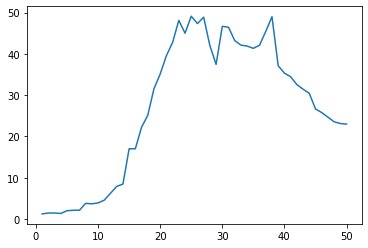

In [877]:
y = z_smooth
x = np.linspace(1, y.shape[0], y.shape[0])
plt.plot(x, y)

In [878]:
dat = z_smooth

validation_steps = 0

X_train = np.arange(dat.shape[0] - validation_steps)
y_train = dat[:dat.shape[0] - validation_steps]

X_test = np.arange(dat.shape[0] - validation_steps, dat.shape[0])
y_test = dat[dat.shape[0] - validation_steps:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50,) (50,) (0,) (0,)


In [879]:
print(X_train, y_train)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [1.222 1.444 1.444 1.333 2.000 2.111 2.111 3.778 3.667 3.889 4.556 6.222
 7.889 8.444 17.000 17.000 22.222 25.111 31.556 35.111 39.556 42.778
 48.111 45.000 49.111 47.333 48.889 42.000 37.444 46.667 46.444 43.222
 42.111 41.889 41.333 42.111 45.444 49.000 37.111 35.333 34.444 32.556
 31.444 30.444 26.667 25.778 24.667 23.556 23.111 23.000]


In [880]:
def erf_model(x, max_val, loc, scale):
    return max_val*(1 + scipy.special.erf(scale*(x - loc)))

def skew_model(x, max_val, loc, scale, a, shift):
    return max_val * stats.skewnorm.pdf(x, a, loc, scale) + shift

def exp_model(x, max_val, loc, scale, K, shift):
    return max_val*stats.exponnorm.pdf(x, K, loc, scale) + shift

def exp_modelcdf(x, max_val, loc, scale, K, shift):
    return max_val*stats.exponnorm.cdf(x, K, loc, scale) + shift

erf_bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
other_bounds = ([z.max(), 0, 0, 0, 0], [100*z.max(), np.inf, np.inf, 10, np.inf])

model = exp_model
bounds = other_bounds
popt, pcov = curve_fit(model, X_train, y_train, bounds=bounds)

In [881]:
print(popt)

[1976.042 17.936 5.171 5.741 1.228]


In [882]:
errors = np.sqrt(np.diag(pcov))
print(errors)

[138.938 0.401 0.471 0.955 1.137]


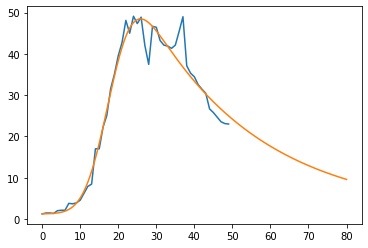

In [883]:
d = z_smooth
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(0, 80, 1000)
y = exp_model(x, *popt)
# x = np.linspace(0, d.shape[0] + 19, d.shape[0] + 20)
# y = exp_modelcdf(x, *popt)
# y0 = [z[0]]
# y = np.concatenate([y0, np.diff(y)])
plt.plot(x, y)

#plt.plot(X_train, y_train, marker='o', linewidth=0)
#plt.plot(X_test, y_test, marker='o', linewidth=0)

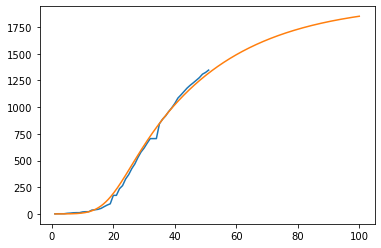

In [884]:
d = z
x = np.linspace(1, d.shape[0], d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(1, 100, 1000)
y = exp_modelcdf(x, *popt)
plt.plot(x, y)

In [848]:
d = z1
x = np.linspace(1, d.shape[0], d.shape[0])
y = model(x, *popt)

residuals = z1 - y
print(residuals)

[0.877 0.877 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123
 -0.123 -0.123 -0.123 -0.123 -0.123 -0.123 -0.124 -0.126 -0.131 -0.144
 -0.171 -0.219 0.705 -0.400 -0.525 -0.654 0.235 1.159 -0.877 -0.875 1.154
 -0.801 2.251 0.303 -0.648]


In [849]:
import curvefit_pipeline as p
import curvefit_models as models
importlib.reload(p)
importlib.reload(models)

<module 'curvefit_models' from '..\\curvefit_models.py'>

In [483]:
data_format = {'name': 'deaths_raw', 'smoothing': 9, 'val_steps': 10}
model_params = {'name': 'ExpNormModel'}
horizon = 14

In [484]:
pipeline = p.Pipeline(data_format, model_params, horizon)

In [454]:
pipeline.run()

In [455]:
use_c = pipeline.use_cumulative

In [874]:
use_c[1879]

True

In [456]:
t = 0
f = 0
for i in use_c:
    if use_c[i]:
        t += 1
    else:
        f += 1
print(t, f)

834 529


In [592]:
data_format = {'name': 'deaths_raw', 'smoothing': 9, 'val_steps': 0}

In [597]:
pipeline2 = p.Pipeline(data_format, model_params, horizon, use_c)
pipeline2.run()

In [598]:
quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [816]:
predictions = pipeline2.get_combined_predictions(quantiles=quantiles, samples=1000)

In [638]:
pred2 = pipeline2.get_combined_predictions()

In [590]:
self = pipeline2.models[1887]
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:.3f}'.format})
x = np.arange(0, 60)
samples = 100
errors = np.sqrt(np.diag(self.pcov))
all_samples = []

errors = np.sqrt(np.diag(self.pcov))
## High errors for pre-peak/mid-peak counties
## Make errors max 1/3 of mean value
for i, err in enumerate(errors):
    if err > (1/3)*self.popt[i]:
        errors[i] = (1/3)*self.popt[i]
        
print(self.popt)
print(errors)

for i in range(samples):
    sample_params = np.random.normal(loc=self.popt, scale=errors)



    for i, param in enumerate(sample_params):
        lower_bound = self.bounds[0][i]
        upper_bound = self.bounds[1][i]

        epsilon = 1e-5
        if param < lower_bound:
            sample_params[i] = lower_bound + epsilon
        elif param > upper_bound:
            sample_params[i] = upper_bound

    y = self.predict(x, sample_params)
    if (np.any(np.isnan(y))):
        continue
    all_samples.append(y)

all_samples = np.array(all_samples)
quantile_predictions = np.array([np.percentile(all_samples, p, axis=0) 
    for p in quantiles])
#print(all_samples.shape)
print(quantile_predictions)
quantile_predictions = quantile_predictions.T
quantile_predictions[quantile_predictions < 0] = 0

y_pred = self.predict(x)
print(y_pred)


[1749.911 8.927 2.634 10.000]
[219.220 0.441 0.588 3.333]
[[0.002 0.012 0.072 0.371 1.325 3.922 8.303 14.745 20.742 27.272 32.510
  36.217 39.170 40.790 41.481 40.881 39.889 38.731 37.825 36.537 35.384
  34.017 32.835 31.693 30.448 29.374 28.378 26.791 25.908 24.978 24.002
  22.903 21.374 20.442 19.934 18.779 17.555 16.560 15.669 14.623 13.895
  12.956 12.085 11.272 10.514 9.807 9.148 8.533 7.963 7.451 6.972 6.523
  6.104 5.711 5.344 5.000 4.682 4.384 4.105]
 [0.019 0.081 0.292 0.989 2.325 5.248 9.951 15.987 22.549 29.219 35.290
  40.560 43.944 45.858 45.557 44.870 44.413 43.174 41.709 40.079 38.405
  36.858 35.439 34.022 32.628 31.356 29.744 28.428 27.465 26.371 25.304
  24.207 23.184 22.345 21.208 20.202 19.299 18.377 17.328 16.512 15.867
  14.944 14.111 13.274 12.533 11.866 11.156 10.517 10.042 9.458 8.929
  8.441 7.994 7.572 7.171 6.792 6.432 6.092 5.770]
 [0.041 0.145 0.452 1.213 3.000 6.061 10.666 17.522 25.372 33.105 39.386
  44.021 46.833 48.002 48.120 47.372 46.121 44.565 42.9

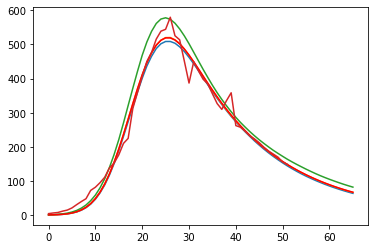

In [888]:
# 1208**, 1200, 716, 1382, 204, 1791, 1868, 1858, 2969, 1887, 1308, 1224, 1776-1794, 2289**, 2848, 3087**, 1138*, 1280, 1293**, 1870**
county = 1858
x = np.arange(0, predictions[county].shape[0])
y = predictions[county][:, 3]
plt.plot(x, y)

y = predictions[county][:, 4]
plt.plot(x, y)

y = predictions[county][:, 8]
plt.plot(x, y)

x = np.arange(0, pred2[county].shape[0])
y = pred2[county]
plt.plot(x, y, color='red')

d = pipeline2.data.daily_smoothed[county]
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)


In [172]:
print(len(pipeline2.models))

1520


In [761]:
data = u.load_covid_static()

c:\users\kehua\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [780]:
data.iloc[1208]

FIPS                            24033
County Name    Prince George's County
cases                             NaN
deaths                            NaN
log_cases                         NaN
log_deaths                        NaN
Name: 1208, dtype: object